In [48]:
# Original file name: tis.ipynb from Rare Event Summer School in Dropbox
# New file name: TPS.ipynb
# Modified by PH Minh
# Last Updated Date: 03-13-2023 

## Simulation Settings

In [5]:
import numpy as np
import sys
import math
import copy
from math import exp
import langevin_dynamics as ld
import random
import matplotlib.pyplot as plt
from matplotlib import colors, ticker, cm
%matplotlib inline

# TPS settings
n_moves = 1000              # number of moves to perform for each path ensemble - path ensemble corresponding to each diff interface
n_discard = 50              # number of moves to discard at the beginning of RETIS - we do this to decorrelate new paths from old paths
op_type = 1                 # order parameter;  1:x  2:y  3:x+y
basinA = -2.09              # boundary of basin A; must be less than the first interface
basinB = 2                  # basin B defined as last interface
init_coords = [-2, -2]      # initial coordinates
init_p = [0, 0]             # initial momenta
basineqlen = 5000           # basin equilibration length (steps)
basinlen = 50000            # basin simulation length
sigma = 0.5                 # standard deviation of momenta perturbation

#Langevin dynamics settings
beta = 2.5                  # 1/kT
gamma = 5.0                 # friction
dt = 0.01                   # time step size
pes_type = 1                # select the type of PES

## Plot potential energy surface contours

<function matplotlib.pyplot.show(close=None, block=None)>

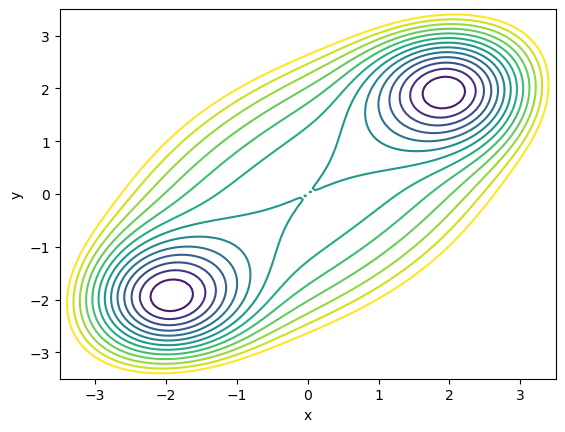

In [6]:
# Plot potential energy surface contours
N = 100
x_vec = np.linspace(-3.5, 3.5, N)
y_vec = np.linspace(-3.5, 3.5, N)
X, Y = np.meshgrid(x_vec, y_vec)
energy = np.zeros((N, N))
for i in range(len(x_vec)):
    for j in range(len(y_vec)):
        energy[j][i] = ld.potential(x_vec[i],y_vec[j],pes_type)
plt.contour(x_vec,y_vec,energy,[-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,2.5,3])
plt.xlabel('x')
plt.ylabel('y')
plt.show

## Generate the initial paths by simulating at a higher temperature

In [9]:
# Run at higher temperature to generate an initial path
initpath = []
beta_initpath = 1.5                                                     # this controls the temperature because beta = 1/kb*T
fromBasin = False

# Calculate initial forces
fx,fy = ld.force(init_coords[0],init_coords[1],init_p[0],init_p[1],dt,beta,gamma,pes_type)

# Combine positions, momenta, and forces to make an initial phase point
init_phasepoint = init_coords + init_p + [fx,fy]

# Use init_phasepoint to start trajectory
trajstep = ld.vv_step(init_phasepoint,dt,beta_initpath,gamma,pes_type)  # array of x, y, px, py, fx, fy to get the first config to generate a path
op = ld.calc_op(op_type,trajstep[0],trajstep[1])                        # calculate the op to see where this config is at, in A or pass A and cross some lambda, or in B?

while op < basinB:                                                      # as long as it is not in B
    nextstep = ld.vv_step(trajstep,dt,beta_initpath,gamma,pes_type)              # generate next config
    trajstep = nextstep                                                 # save this config to trajstep, so we could shoot from it again 
    op = ld.calc_op(op_type,trajstep[0],trajstep[1])

    if op < basinA:                                                     # if this then this traj is from basin A 
        fromBasin = True
        initpath = []                                                   # reset path if it returns to A - do this until it's about to leave the basin
        trajstep = np.append(trajstep,[op],axis=0)                      # array of x, y, px, py, fx, fy and op value
        initpath.append(trajstep) 
        continue

    if op >= basinA and fromBasin == True:                              # now that you have left basin A, we'll save the different configs to the list initpath
        trajstep = np.append(trajstep,[op],axis=0)
        initpath.append(trajstep)
        continue

initpath = np.asarray(initpath)                                         # this gives all configurations of this 1 initial path

allpaths = []                                                           # list to keep track of the TPE
allpaths.append(initpath)                                               # append the initial path into this list to get our simulation started                                        


## Perform TPS

In [10]:
acc = 0
successful_paths = []

for move in range(1, n_moves):
    print('Move =', move)

    # Perform shooting move
    print('Performing Shoot Move')

    path = allpaths[move-1]                                                 # looks at the most current path of the TPE of interface i
    reject_move = False
    lmax = round((len(path) + 1)/np.random.uniform())                       # l max = maximum path length for flexible shooting 
    # print(lmax)

    # Pick random shooting point
    index = np.random.randint(len(path) - 2) + 1                            # minus 2 to avoid basinA and i+1 points

    # Perturb the momenta
    shoot_point = copy.deepcopy(path[index])                                # gives me 1 phase space point/config along the path
    shoot_point[2] += np.random.normal(0,sigma)                             # px
    shoot_point[3] += np.random.normal(0,sigma)                             # py
    trial_path = np.asarray([shoot_point])                                  # new trial path after perturbing the momenta

    if exp(-beta*(ld.kinetic_energy(shoot_point) - ld.kinetic_energy(path[index]))) < np.random.uniform():
        # the if is testing to see if we want to use this new trial path (after momenta is perturbed) 
        # before even shooting it
        reject_move = True
        print('Shooting Move Rejected! Momenta pertubation unsuccessful!')

    # Integrate backwards path if we have not rejected the move...
    if reject_move == False:
        path_length = 1
        trial_path[:,2] *=-1                                                # change px to the negative direction by * -1
        trial_path[:,3] *=-1                                                # change py to the negative direction by * -1
        trajstep = copy.deepcopy(trial_path[-1])                            # take the last config of trial path
        op = ld.calc_op(op_type,trajstep[0],trajstep[1])                    # calc op value for config

        while op >= basinA:
            trajstep = ld.vv_step(trajstep[:6],dt,beta,gamma,pes_type)      # ld.vv_step(x,y,px,py,fx,fy,dt,beta,gamma)
            op = ld.calc_op(op_type,trajstep[0],trajstep[1])
            trajstep = np.append(trajstep,[op],axis=0)
            trial_path = np.append(trial_path,[trajstep],axis=0)
            path_length +=1

            # Reject if the maximum path length is exceeded
            if path_length > lmax:
                reject_move = True
                print('Shooting Move Rejected! Path length limit.')
                break

            # Reject if the backward path segment goes to B
            if op >= basinB:
                reject_move = True
                print('Shooting Move Rejected! Backward path goes to B.')
                break

    # Forward shooting             
    if reject_move == False: 
        trial_path = np.flip(trial_path,axis=0)                             # flip it from the back to front of this trial path (because it was shooting backwards), so we flip so that the last config we extract from here will be where we'll use to shoot forward
        trial_path[:,2] *=-1
        trial_path[:,3] *=-1
        trajstep = copy.deepcopy(trial_path[-1])
        op = ld.calc_op(op_type,trajstep[0],trajstep[1])

#             while op >= basinA and op < interfaces[i+1]: 
# COMMENT OUT FOR NOW BECAUSE WE'RE USING RETIS, UNCOMMENT FOR TIS

        while op < basinB:                                                  # this is so that it restricts forward shooting to end in B

            nextstep = ld.vv_step(trajstep[:6],dt,beta,gamma,pes_type)
            trajstep = nextstep
            op = ld.calc_op(op_type,trajstep[0],trajstep[1])
            trajstep = np.append(trajstep,[op],axis=0)
            trial_path = np.append(trial_path,[trajstep],axis=0)
            path_length +=1
            
            if path_length > lmax:
                reject_move = True
                print('Shooting Move Rejected! Path Length Limit!')
                break
            
            if op <= basinA:
                reject_move = True
                print('Shooting Move Rejected! Forward section reached A!')
                break
    
    # If we DON'T reject, then path becomes trial path
    if reject_move == False:
        print('Shooting Move Accepted!')
        path = trial_path
        acc += 1
        successful_paths.append(path)                                                            # path is accepted everytime path crosses i
    
    # Append current accepted path to its corresponding path ensemble
    allpaths.append(path)                                               # all paths contains all paths per each interface - i is to signify which interface ensemble we're looking at. So allpaths[0] will contain all paths that cross interface lambda 0

    # Calculate acceptance probability
    print('Acceptance Probability: {}'.format(acc/n_moves))

Move = 1
Performing Shoot Move
Shooting Move Rejected! Momenta pertubation unsuccessful!
Acceptance Probability: 0.0
Move = 2
Performing Shoot Move
Shooting Move Rejected! Momenta pertubation unsuccessful!
Acceptance Probability: 0.0
Move = 3
Performing Shoot Move
Shooting Move Rejected! Momenta pertubation unsuccessful!
Acceptance Probability: 0.0
Move = 4
Performing Shoot Move
Shooting Move Rejected! Forward section reached A!
Acceptance Probability: 0.0
Move = 5
Performing Shoot Move
Shooting Move Rejected! Path Length Limit!
Acceptance Probability: 0.0
Move = 6
Performing Shoot Move
Shooting Move Rejected! Backward path goes to B.
Acceptance Probability: 0.0
Move = 7
Performing Shoot Move
Shooting Move Accepted!
Acceptance Probability: 0.001
Move = 8
Performing Shoot Move
Shooting Move Accepted!
Acceptance Probability: 0.002
Move = 9
Performing Shoot Move
Shooting Move Rejected! Forward section reached A!
Acceptance Probability: 0.002
Move = 10
Performing Shoot Move
Shooting Move R

## Plot the paths collected at each interface

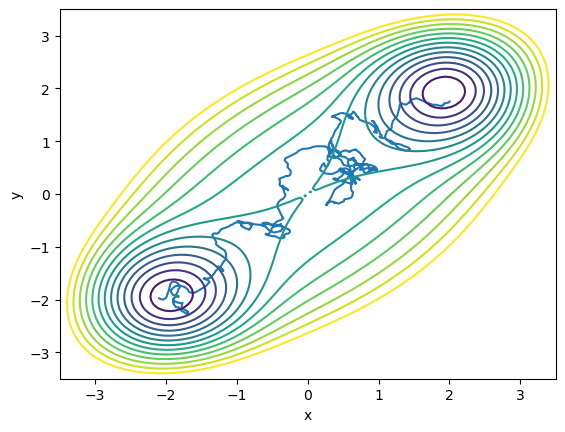

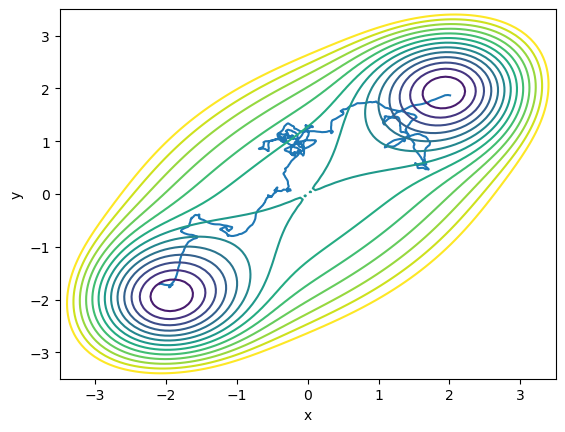

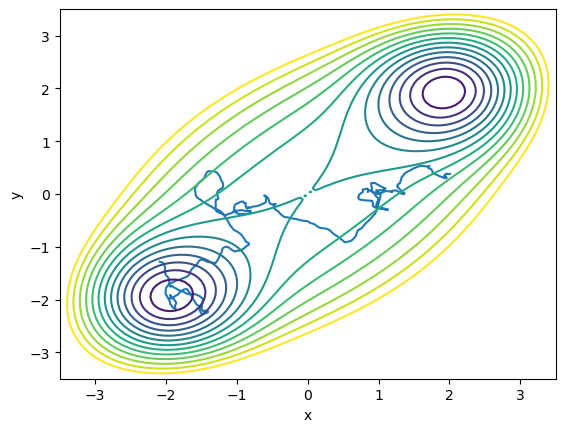

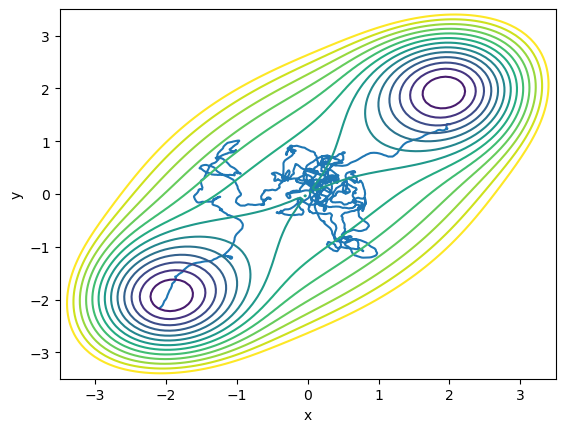

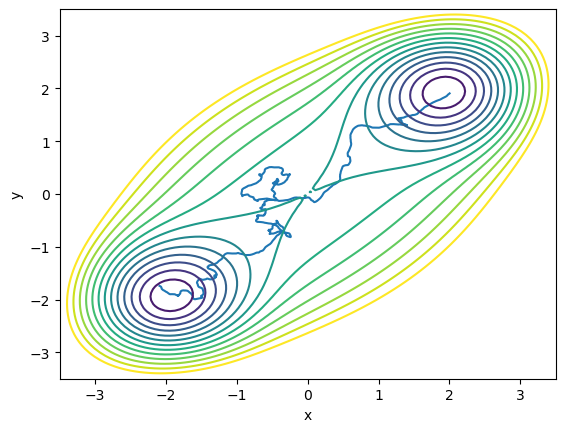

In [14]:

for j in range(0,len(successful_paths),10):
    plt.plot(successful_paths[j][:,0],successful_paths[j][:,1])
    plt.contour(x_vec,y_vec,energy,[-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,2.5,3]) # plot the energy landscape/contour
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()


## Check the path correlation

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


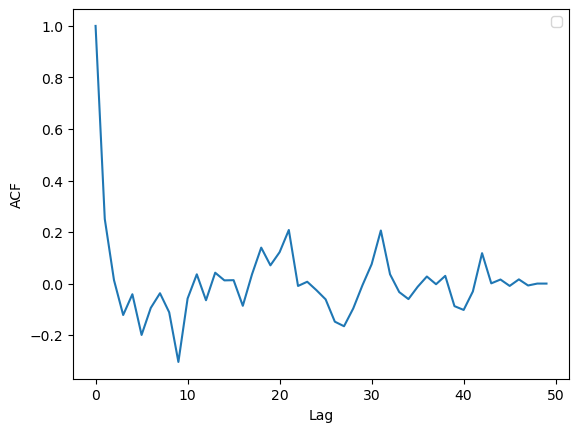

In [11]:
""" Autocorrelation Graph: Criteria = Pathlength """
""" The equation used for ACF calculation is:   [INSERT]           """

maxlag = 50                                                 # Define your max lag
acf_p = [] 

pathlengthsvals = []                                        # List to store pathlength values of each path of an interface ensemble

start = 0                                                   # You define what move the ACF starts at, this should correspond to where the 
                                                            # running average crossing prob. converges

# Gather information about each move for an interface ensemble
for move in range(start,len(successful_paths)):                   
    pathlengthsvals.append(len(successful_paths[move]))

# Calculate ACF 
# Get mean 
pl = np.asarray(pathlengthsvals)

plavg = np.mean(pl)

# Get denominator
denom_pl = np.sum((pl-plavg)**2)

# Get numerator 
for lag in range(maxlag):
    sample = len(pl) - lag                                    # Number of samples that we're going to calculate ACF over
    
    acfpl = 0

    for j in range(sample):
        numer_pl = (pl[j] - plavg)*(pl[j+lag] - plavg)

        # Get ACF values
        acfpl += numer_pl/denom_pl

    acf_p.append(acfpl)

# Plot ACF Graphs 

plt.plot(range(0,lag+1),acf_p)
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.legend()
plt.show()
